<a href="https://colab.research.google.com/github/julia254/Machine-Learning/blob/main/monet_style_transfer_with_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monet Style Transfer with Generative Adversarial Networks

This notebook utilizes Generative Adversarial Networks (GANs) architecture to add Monet's painting style to a set of photos. I will use the TFRecords dataset containing 300 Monet paintings and 7028 photos. All the images for the competition are sized to 256x256 and contain 3 RBG channels.

The dataset is available on [Kaggle](https://www.kaggle.com/competitions/gan-getting-started/data).

In [ ]:
import os
import pandas as pd
import PIL
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, Input
from tensorflow.keras.layers import ZeroPadding2D, GroupNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

# Load the data


In [ ]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [ ]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [ ]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = (tf.cast(image, tf.float32) / 127.5) - 1
  image = tf.reshape(image, [*IMAGE_SIZE, 3])
  return image


def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord) #num_parallel_calls=AUTOTUNE
    return dataset


In [ ]:
monet_data = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_data = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

Visualize an photo example and monet example.

In [ ]:
# Fetch example photos

example_monet = next(iter(monet_data))
example_photo = next(iter(photo_data))

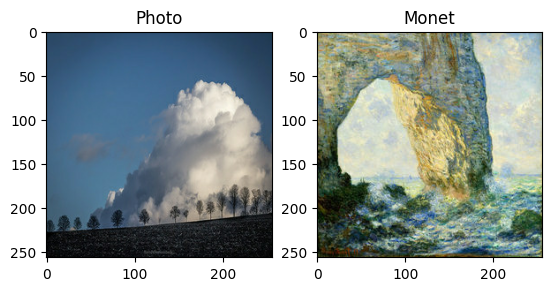

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0]* 0.5 + 0.5 )

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0]* 0.5 + 0.5)

# Model Architecture

CycleGAN performs unpaired image-to-image translation by enforcing a cycle consistency loss. It does not require paired datasets, making it highly versatile for style transfer tasks. CycleGAN is ideal for style transfer between two domains where paired examples are not available (e.g., transforming photographs into paintings).

We'll be using a U-NET architecture for our CycleGAN. To train a CycleGAN for style transfer (e.g., transferring the style of Monet paintings onto photos), you need to:

**Define the Generator and Discriminator models:** The generator transforms a photo into a Monet-style painting, while the discriminator distinguishes between generated Monet-style images and real Monet paintings.

**Set up the CycleGAN architecture:** CycleGAN consists of two generators and two discriminators:

- Generator G: Transforms photos into Monet-style paintings.
- Generator F: Transforms Monet-style paintings back into photos (cycle consistency).
- Discriminator DX: Discriminates between real photos and generated photos from G.
- Discriminator DY: Discriminates between real Monet paintings and generated paintings from F.


**Implement loss functions:**

- Adversarial loss: Encourages generators to generate realistic images to fool the discriminators.
- Cycle consistency loss: Ensures that after transformation and inverse transformation, the output is similar to the original image.
- Identity loss: Ensures that an image from the target domain (e.g., Monet painting) remains unchanged when passed through the generator designed to generate that domain.


**Train the CycleGAN:** Use both sets of generators and discriminators for adversarial training

# Define the Generator Model

To build our generator, let's first define our downsample and upsample methods. The downsample, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.



In [ ]:

def downsample_block(inputs, filters, apply_instancenorm=True ):  # dropout_rate=0.1
 #  """Downsampling block with Conv2D""" #

  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  # first convolutional layer
  conv = Conv2D(filters, (3, 3), strides=2, padding='same',
                kernel_initializer=initializer, use_bias=False)(inputs)

  #conv = Dropout(dropout_rate)(conv)

  # Apply GroupNormalization if required
  if apply_instancenorm:
        conv = GroupNormalization(gamma_initializer=gamma_init)(conv)

  conv = LeakyReLU()(conv)

  # second convolutional layer
  #conv = Conv2D(filters, (3, 3), strides=2, padding='same',
   #            kernel_initializer=initializer, use_bias=False)(conv)

  conv = LeakyReLU()(conv)

  #pool = MaxPooling2D((2, 2))(conv)

  return conv


def upsample_block(inputs, skip_features, filters, apply_dropout=False):
#  """Upsampling block with Conv2D"""#

  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  upsample = Conv2DTranspose(filters, (4, 4), strides=(2, 2), padding='same',
                             kernel_initializer=initializer, use_bias=False)(inputs)


  upsample = GroupNormalization(gamma_initializer=gamma_init)(upsample )

  # Optional dropout
  if apply_dropout:
    conv = Dropout(0.5)(upsample )

    # Apply ReLU activation
  conv = LeakyReLU()(upsample )

  concat = concatenate([upsample, skip_features])

  conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(concat)

  return conv


OUTPUT_CHANNELS = 3

def build_unet_generator():

  inputs = Input(shape=([256, 256, 3]))
  initializer = tf.random_normal_initializer(0., 0.02)

  # Contracting Path (Downsampling)
  c1 = downsample_block(inputs, 64, apply_instancenorm=False)
  c2 = downsample_block(c1, 128)
  c3 = downsample_block(c2, 256)
  c4 = downsample_block(c3, 512)
  c5 = downsample_block(c4, 512)
  c6 = downsample_block(c5, 512)
  c7 = downsample_block(c6, 512)

  bottleneck = downsample_block(c7, 512)
  # Bottleneck
 # bottleneck = Conv2D(1024, (3, 3), activation='relu', padding='same')(c7)
 # bottleneck = Dropout(0.3)(bottleneck)
  #bottleneck = Conv2D(1024, (3, 3), activation='relu', padding='same')(bottleneck)

  # Expansive Path (Upsampling)
  u1 = upsample_block(bottleneck, c7, 512, apply_dropout=True)
  u2 = upsample_block(u1, c6,  512, apply_dropout=True)
  u3 = upsample_block(u2, c5, 512, apply_dropout=True)
  u4 = upsample_block(u3, c4, 512)
  u5 = upsample_block(u4, c3, 256)
  u6 = upsample_block(u5, c2, 128)
  u7 = upsample_block(u6, c1, 64)


  outputs = Conv2DTranspose(OUTPUT_CHANNELS, (3, 3), strides=2, padding='same',
                            kernel_initializer=initializer,activation='tanh')(u7)

  model = Model(inputs, outputs)

  return model

# Define the Disciminator Model

In [ ]:
def build_unet_discriminator():
    input = Input(shape=([256, 256, 3]))

    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    d1 = downsample_block(input, 64)
    d2 = downsample_block(d1, 128)
    d3 = downsample_block(d2, 256)
    d4 = ZeroPadding2D()(d3)

    d5 = Conv2D(512, 4, strides=1,
                kernel_initializer=initializer,use_bias=False)(d4)

    norm1 = GroupNormalization(gamma_initializer=gamma_init)(d5)

    leaky_relu = LeakyReLU()(norm1)

    d6 = ZeroPadding2D()(leaky_relu)

    output = Conv2D(1, 4, strides=1,
                    kernel_initializer=initializer)(d6)

    return Model(inputs = input, outputs = output)


# Initialize the Models

In [ ]:
# Initialize generator
monet_generator = build_unet_generator()
photo_generator = build_unet_generator()

monet_generator.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,728 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ leaky_re_lu[0][0] │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     73,728 │ leaky_re_lu_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (GroupNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ group_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ leaky_re_lu_2[0]… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    294,912 │ leaky_re_lu_3[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (GroupNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ group_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 32, 32,    │          0 │ leaky_re_lu_4[0]… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  1,179,648 │ leaky_re_lu_5[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_3[0][0]    │
│ (GroupNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 16, 16,    │          0 │ group_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 16, 16,    │          0 │ leaky_re_lu_6[0]… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  2,359,296 │ leaky_re_lu_7[0]

 Total params: 50,954,691 (194.38 MB)

 Trainable params: 50,954,691 (194.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initialize discriminator
monet_discriminator = build_unet_discriminator()
photo_discriminator = build_unet_discriminator()

monet_discriminator.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_28          │ (None, 128, 128, 64)   │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_46 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_47 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_29          │ (None, 64, 64, 128)    │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_30          │ (None, 32, 32, 256)    │           512 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 31, 31, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_31          │ (None, 31, 31, 512)    │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_52 (LeakyReLU)      │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 33, 33, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 30, 30, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,477,633 (9.45 MB)

 Trainable params: 2,477,633 (9.45 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model



1. CycleGAN Architecture
Generators:
Generator G: Transforms photos to Monet-style paintings.
Generator F: Transforms Monet-style paintings to photos.
Discriminators:
Discriminator DX: Discriminates between real photos and generated photos.
Discriminator DY: Discriminates between real Monet paintings and generated paintings.

2. Loss Functions
Adversarial Loss: For each discriminator, calculated as a binary cross-entropy between real and fake images.
Cycle Consistency Loss: Ensures that if you translate a photo to a Monet painting and then back to a photo, the output should be close to the original photo.
Identity Loss: Ensures that images from the target domain remain unchanged when passed through the corresponding generator.

In [ ]:
class CycleGAN (Model):
  def __init__(self,
               monet_generator,
               photo_generator,
               monet_discriminator,
               photo_discriminator,
               lambda_cycle=10,
               lambda_identity=10):
    super(CycleGAN, self).__init__()
    self.monet_generator = monet_generator # Photo to Monet
    self.photo_generator = photo_generator # Monet to Photo
    self.monet_discriminator = monet_discriminator # Distinguish Real Monet Painting vs Generated Monet
    self.photo_discriminator = photo_discriminator # Distinguish Real Photo Painting vs Generated Photo

    # Optimizers
    self.monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    self.photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    self.monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    self.photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    # Loss Function
    self.loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True) # ,reduction=tf.keras.losses.Reduction.NONE
    self.lambda_cycle = lambda_cycle
    self.lambda_identity = lambda_identity

    # Initialize loss function attributes
    self.gen_loss = self.generator_loss
    self.disc_loss = self.discriminator_loss
    self.cycle_loss = self.cycle_consistency_loss
    self.identity_loss = self.identity_loss

  def generator_loss(self, fake_output):
    return self.loss_obj(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(self, real_output, fake_output):
    real_loss = self.loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = self.loss_obj(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

  def cycle_consistency_loss(self, real_image, cycled_image):
    cycle_loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return cycle_loss * self.lambda_cycle

  def identity_loss(self, real_image, same_image):
    id_loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return id_loss * self.lambda_identity

  #def compile(self, generator_optimizer, discriminator_optimizer,
   #         gen_loss, disc_loss, cycle_loss, identity_loss):
   ## self.generator_optimizer = generator_optimizer
    ##self.gen_loss = gen_loss
    #self.disc_loss= disc_loss
    #self.cycle_loss = cycle_loss
    #self.identity_loss = identity_loss

  def compile(self,
            monet_generator_optimizer=None,
            photo_generator_optimizer=None,
            monet_discriminator_optimizer=None,
            photo_discriminator_optimizer=None,
            gen_loss=None,
            disc_loss=None,
            cycle_loss=None,
            identity_loss=None):
    super(CycleGAN, self).compile()

    self.monet_generator_optimizer = self.monet_generator_optimizer
    self.photo_generator_optimizer = self.photo_generator_optimizer
    self.monet_discriminator_optimizer = self.monet_discriminator_optimizer
    self.photo_discriminator_optimizer = self.photo_discriminator_optimizer

    self.gen_loss = gen_loss if gen_loss else self.gen_loss
    self.disc_loss = disc_loss if disc_loss else self.disc_loss
    self.cycle_loss = cycle_loss if cycle_loss else self.cycle_loss
    self.identity_loss = identity_loss if identity_loss else self.identity_loss


  def train_step(self, data):
    real_monet, real_photo = data

    with tf.GradientTape(persistent=True) as tape:

    # Generator: Photo -> Monet -> Photo
      fake_monet = self.monet_generator(real_photo, training=True)
      cycled_photo = self.photo_generator(fake_monet, training=True)

      # Generator: Monet -> Photo -> Monet
      fake_photo = self.photo_generator(real_monet, training=True)
      cycled_monet = self.monet_generator(fake_photo, training=True)

      # Identity mapping
      same_monet = self.monet_generator(real_monet, training=True)
      same_photo = self.photo_generator(real_photo, training=True)


      # Discriminator predictions
      disc_real_monet = self.monet_discriminator(real_monet, training=True)
      disc_real_photo = self.photo_discriminator(real_photo, training=True)
      disc_fake_monet = self.monet_discriminator(fake_monet, training=True)
      disc_fake_photo = self.photo_discriminator(fake_photo, training=True)

       ## Generator losses
       # Generative Adversarial Loss
      monet_gen_loss = self.generator_loss(disc_fake_monet)
      photo_gen_loss = self.generator_loss(disc_fake_photo)

       # Cycle consistency loss
      monet_cycle_loss = self.cycle_consistency_loss(real_monet, cycled_monet)
      photo_cycle_loss = self.cycle_consistency_loss(real_photo, cycled_photo)

       # evaluates total cycle consistency loss
      total_cycle_loss = monet_cycle_loss + photo_cycle_loss

       # Identity loss
      monet_identity_loss = self.identity_loss(real_monet, same_monet)
      photo_identity_loss = self.identity_loss(real_photo, same_photo)

      total_monet_gen_loss = monet_gen_loss + total_cycle_loss + monet_identity_loss
      total_photo_gen_loss = photo_gen_loss + total_cycle_loss + photo_identity_loss

#total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) +
                  #self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
# evaluates total generator loss
#total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
#total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Discriminator losses
      monet_disc_loss = self.discriminator_loss(disc_real_monet, disc_fake_monet)
      photo_disc_loss = self.discriminator_loss(disc_real_photo, disc_fake_photo)


# Calculate the gradients and apply them
    monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.monet_generator.trainable_variables)
    photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.photo_generator.trainable_variables)
    monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.monet_discriminator.trainable_variables)
    photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.photo_discriminator.trainable_variables)

    self.monet_generator_optimizer.apply_gradients(zip(monet_generator_gradients, self.monet_generator.trainable_variables))
    self.photo_generator_optimizer.apply_gradients(zip(photo_generator_gradients, self.photo_generator.trainable_variables))
    self.monet_discriminator_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.monet_discriminator.trainable_variables))
    self.photo_discriminator_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.photo_discriminator.trainable_variables))

    return {
        "monet_gen_loss": total_monet_gen_loss,
        "photo_gen_loss": total_photo_gen_loss,
        "monet_disc_loss": monet_disc_loss,
        "photo_disc_loss": photo_disc_loss,
        }

def train(self, monet_dataset, photo_dataset, epochs):
        for epoch in range(epochs):
            for real_monet, real_photo in zip(monet_dataset, photo_dataset):
                losses = self.train_step(real_monet, real_photo)

            # Print out the losses for monitoring
            print(f"Epoch {epoch + 1}, "
                  f"monet_gen_loss: {losses['monet_gen_loss']:.4f}, photo_gen_loss: {losses['photo_gen_loss']:.4f}, "
                  f"monet_disc_loss: {losses['monet_disc_loss']:.4f}, photo_disc_loss: {losses['photo_disc_loss']:.4f}")




In [ ]:
cycle_gan_model = CycleGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

cycle_gan_model.compile()

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip(monet_data, photo_data),
    epochs = 25
    )

Epoch 1/25


I0000 00:00:1729013851.833566      68 service.cc:145] XLA service 0x7b6934003780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729013851.833629      68 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729013851.833634      68 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729013910.361910      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 199s 231ms/step - monet_disc_loss: 0.5205 - monet_gen_loss: 7.5490 - photo_disc_loss: 0.3830 - photo_gen_loss: 8.4629
Epoch 2/25


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 239ms/step - monet_disc_loss: 0.5744 - monet_gen_loss: 4.8923 - photo_disc_loss: 0.5802 - photo_gen_loss: 4.9473
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 238ms/step - monet_disc_loss: 0.5270 - monet_gen_loss: 4.6954 - photo_disc_loss: 0.5495 - photo_gen_loss: 4.6953
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 238ms/step - monet_disc_loss: 0.5388 - monet_gen_loss: 4.7690 - photo_disc_loss: 0.5155 - photo_gen_loss: 4.7437
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 238ms/step - monet_disc_loss: 0.4225 - monet_gen_loss: 5.0061 - photo_disc_loss: 0.5016 - photo_gen_loss: 4.6618
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 238ms/step - monet_disc_loss: 0.5414 - monet_gen_loss: 4.5720 - photo_disc_loss: 0.4840 - photo_gen_loss: 4.5885
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 238ms/step - monet_disc_loss: 0.5575 - monet_gen_loss: 4.3438 - photo_disc_loss: 0.4315 - photo_gen_loss: 4.7297
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 238ms/step - monet_disc_l

# Results

In [ ]:
# Data for each epoch
data = {
    'Epoch': list(range(1, 26)),
    'Monet Disc Loss': [0.5205, 0.5744, 0.5270, 0.5388, 0.4225, 0.5414, 0.5575, 0.4237,
                        0.4660, 0.6080, 0.5604, 0.5658, 0.5608, 0.5574, 0.6476,
                        0.6339, 0.6077, 0.5948, 0.5627, 0.5383, 0.5640, 0.5545,
                        0.5672, 0.5237, 0.5456],
    'Monet Gen Loss': [7.5490, 4.8923, 4.6954, 4.7690, 5.0061, 4.5720, 4.3438, 4.7704,
                       4.8716, 4.2275, 4.0518, 3.9445, 3.8783, 3.8635, 3.3284,
                       3.2433, 3.2729, 3.2419, 3.3344, 3.4199, 3.4706, 3.4390,
                       3.2832, 3.3377, 3.3632],
    'Photo Disc Loss': [0.3830, 0.5802, 0.5495, 0.5155, 0.5016, 0.4840, 0.4315, 0.3995,
                        0.3783, 0.5195, 0.5477, 0.5508, 0.5389, 0.5147, 0.5445,
                        0.5564, 0.5533, 0.5309, 0.5685, 0.5423, 0.5611, 0.5543,
                        0.5611, 0.5548, 0.5552],
    'Photo Gen Loss': [8.4629, 4.9473, 4.6953, 4.7437, 4.6618, 4.5885, 4.7297, 4.8950,
                       5.1742, 4.6651, 4.2835, 4.1035, 4.0403, 4.0764, 3.8675,
                       3.7011, 3.5211, 3.5454, 3.4387, 3.4406, 3.4553, 3.4720,
                       3.4405, 3.3109, 3.3635]
}

# Create DataFrame
df_losses = pd.DataFrame(data)

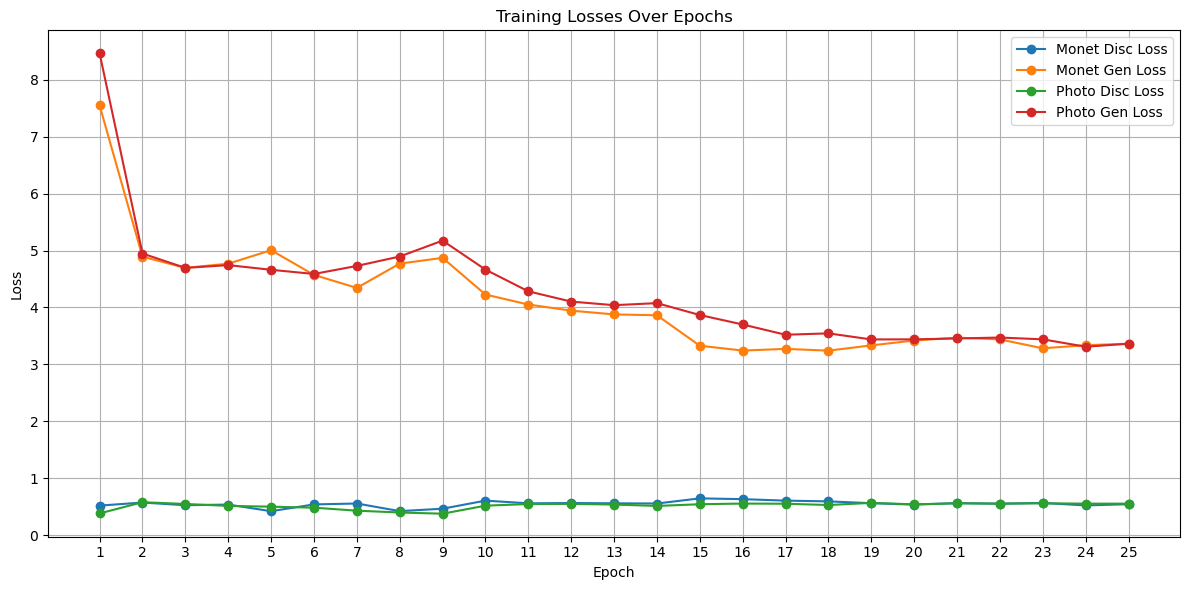

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_losses['Epoch'], df_losses['Monet Disc Loss'], label='Monet Disc Loss', marker='o')
plt.plot(df_losses['Epoch'], df_losses['Monet Gen Loss'], label='Monet Gen Loss', marker='o')
plt.plot(df_losses['Epoch'], df_losses['Photo Disc Loss'], label='Photo Disc Loss', marker='o')
plt.plot(df_losses['Epoch'], df_losses['Photo Gen Loss'], label='Photo Gen Loss', marker='o')


plt.title('Training Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(df_losses['Epoch'])  # Show all epochs on the x-axis
plt.legend()
plt.grid()
plt.tight_layout()


plt.show()

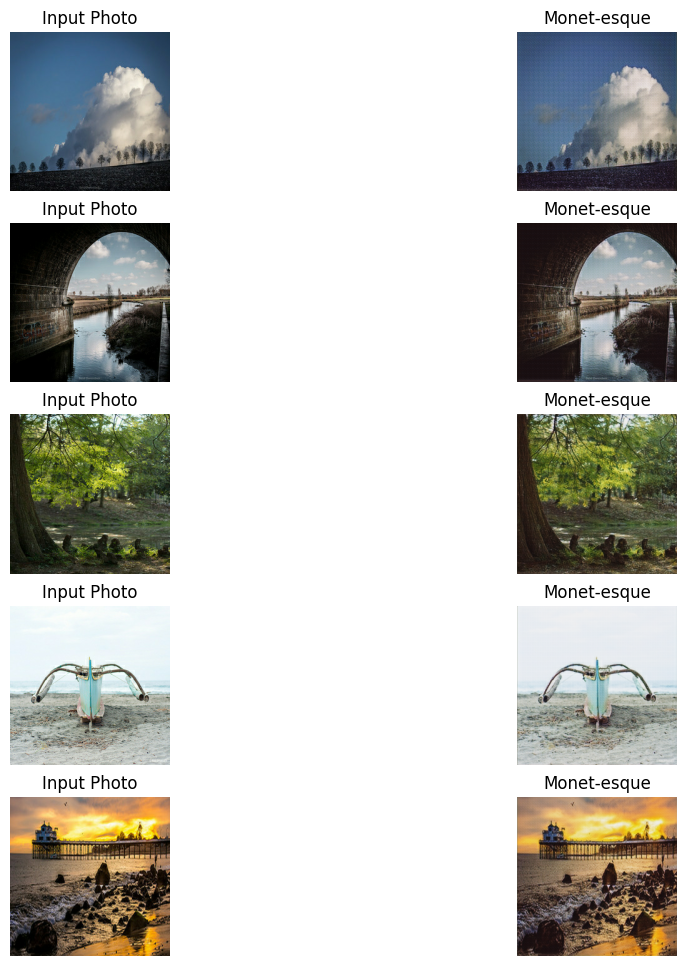

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_data.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create Kaggle Submission File

In [ ]:
import PIL
import os

# Create the images directory
output_dir = '/kaggle/working/images'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created: {output_dir}")

Output directory created: /kaggle/working/images


In [ ]:
# Generate and save images
i = 1
for img in photo_data:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(os.path.join(output_dir, f"{i}.jpg"))  # Save to the images folder
    i += 1


In [ ]:

# Create a zip file of the images directory if it contains files
if os.listdir(output_dir):
    shutil.make_archive('/kaggle/working/images', 'zip', output_dir)
else:
    print("No images to zip.")

# Conclusion

For this Kaggle Competition, implementation of CycleGAN for Monet-style image transfer achieved a Memorization-informed Fréchet Inception Distance (MiFID) of 0.71. This metric, which represents the minimum cosine distance of all training samples in the feature space averaged across user-generated images, indicates a relatively good performance of our model. The lower the MiFID, the higher the quality of the generated images. With the final result being closer to the leaderboard's smallest value of 0.39, it suggests that the generated images maintain a satisfactory level of fidelity to the Monet style.

Additionally, the close alignment of losses for both the generator and discriminator indicates that the model is well-balanced and not overfitting, which is crucial for ensuring generalization to unseen images.

Looking ahead, there are several avenues for enhancing the model's performance. Future improvements could include exploring advanced data augmentation techniques to enrich the training dataset, experimenting with different architectural modifications to the generator and discriminator, or implementing more sophisticated loss functions that emphasize perceptual similarity. Furthermore, leveraging transfer learning with pre-trained networks may provide a stronger feature representation and lead to even better results.